In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/MyDrive/WESAD.zip"

In [ ]:
!unzip "$zip_path" -d "/content/WESAD_raw"

Archive:  /content/drive/MyDrive/WESAD.zip
   creating: /content/WESAD_raw/WESAD/
   creating: /content/WESAD_raw/WESAD/S10/
  inflating: /content/WESAD_raw/WESAD/S10/S10.pkl  
  inflating: /content/WESAD_raw/WESAD/S10/S10_E4_Data.zip  
  inflating: /content/WESAD_raw/WESAD/S10/S10_quest.csv  
  inflating: /content/WESAD_raw/WESAD/S10/S10_readme.txt  
  inflating: /content/WESAD_raw/WESAD/S10/S10_respiban.txt  
   creating: /content/WESAD_raw/WESAD/S11/
  inflating: /content/WESAD_raw/WESAD/S11/S11.pkl  
  inflating: /content/WESAD_raw/WESAD/S11/S11_E4_Data.zip  
  inflating: /content/WESAD_raw/WESAD/S11/S11_quest.csv  
  inflating: /content/WESAD_raw/WESAD/S11/S11_readme.txt  
  inflating: /content/WESAD_raw/WESAD/S11/S11_respiban.txt  
   creating: /content/WESAD_raw/WESAD/S13/
  inflating: /content/WESAD_raw/WESAD/S13/S13.pkl  
  inflating: /content/WESAD_raw/WESAD/S13/S13_E4_Data.zip  
  inflating: /content/WESAD_raw/WESAD/S13/S13_quest.csv  
  inflating: /content/WESAD_raw/WESAD/S

In [ ]:
import pickle
import pandas as pd
import os

wesad_path = "/content/WESAD_raw/WESAD"
all_data = []

# Loop through each subject folder
for subject_folder in sorted(os.listdir(wesad_path)):
    if not subject_folder.startswith("S"):
        continue

    subject_id = subject_folder[1:]  # e.g., "S2" -> "2"
    pkl_path = os.path.join(wesad_path, subject_folder, f"{subject_folder}.pkl")
    print(f"Processing {pkl_path}...")

    # Load pickle
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')

    # Extract each signal separately (chest device)
    chest_signals = data['signal']['chest']
    acc_x = chest_signals['ACC'][:, 0]
    acc_y = chest_signals['ACC'][:, 1]
    acc_z = chest_signals['ACC'][:, 2]
    ecg = chest_signals['ECG'][:, 0]
    emg = chest_signals['EMG'][:, 0]
    eda = chest_signals['EDA'][:, 0]
    temp = chest_signals['Temp'][:, 0]
    resp = chest_signals['Resp'][:, 0]

    # Build DataFrame
    chest_df = pd.DataFrame({
        'ACC_X': acc_x,
        'ACC_Y': acc_y,
        'ACC_Z': acc_z,
        'ECG': ecg,
        'EMG': emg,
        'EDA': eda,
        'TEMP': temp,
        'RESP': resp
    })

    # Downsample to 4 Hz (original 700 Hz)
    ds_factor = int(700 / 4)
    chest_df = chest_df.iloc[::ds_factor, :]

    # Labels (same downsampling)
    labels = pd.Series(data['label'][::ds_factor], name='tag')
    chest_df['tag'] = labels

    # Add subject_id
    chest_df['subject_id'] = subject_id

    all_data.append(chest_df)

# Combine all subjects
merged_df = pd.concat(all_data, ignore_index=True)

# Keep only relevant columns (HR is not computed yet)
final_cols = ['TEMP', 'EDA', 'ACC_Y', 'ACC_Z', 'ACC_X', 'tag', 'subject_id']
merged_df = merged_df[final_cols]

# Save to Drive
output_path = "/content/drive/MyDrive/wesad_reduced.csv"
merged_df.to_csv(output_path, index=False)
print(f"✅ Saved reduced dataset to {output_path}, shape: {merged_df.shape}")


Processing /content/WESAD_raw/WESAD/S10/S10.pkl...
Processing /content/WESAD_raw/WESAD/S11/S11.pkl...
Processing /content/WESAD_raw/WESAD/S13/S13.pkl...
Processing /content/WESAD_raw/WESAD/S14/S14.pkl...
Processing /content/WESAD_raw/WESAD/S15/S15.pkl...
Processing /content/WESAD_raw/WESAD/S16/S16.pkl...
Processing /content/WESAD_raw/WESAD/S17/S17.pkl...
Processing /content/WESAD_raw/WESAD/S2/S2.pkl...
Processing /content/WESAD_raw/WESAD/S3/S3.pkl...
Processing /content/WESAD_raw/WESAD/S4/S4.pkl...
Processing /content/WESAD_raw/WESAD/S5/S5.pkl...
Processing /content/WESAD_raw/WESAD/S6/S6.pkl...
Processing /content/WESAD_raw/WESAD/S7/S7.pkl...
Processing /content/WESAD_raw/WESAD/S8/S8.pkl...
Processing /content/WESAD_raw/WESAD/S9/S9.pkl...
✅ Saved reduced dataset to /content/drive/MyDrive/wesad_reduced.csv, shape: (347472, 7)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

# Load the reduced dataset
df = pd.read_csv("/content/drive/MyDrive/wesad_reduced.csv")
df.head()

,TEMP,EDA,ACC_Y,ACC_Z,ACC_X,tag,subject_id
0,33.695860,0.716019,0.1520,0.3416,1.1278,0.0,10
1,33.753480,0.793839,-0.0362,-0.2702,0.8580,0.0,10
2,33.741333,0.709152,0.0248,-0.2450,0.8904,0.0,10
3,33.729218,0.717163,0.0270,-0.2490,0.8860,1.0,10
4,33.717070,0.720978,0.0490,-0.2378,0.8850,1.0,10


In [ ]:
# Drop NaN and unlabeled (0)
df = df.dropna(subset=['tag'])
df = df[df['tag'] != 0]

# Binary classification: stress=1, everything else=0
df['tag'] = df['tag'].apply(lambda x: 1 if x == 2 else 0)


In [ ]:
# Features and target
X = df.drop(columns=['tag', 'subject_id'])
y = df['tag']
subjects = df['subject_id'].unique()

results = []

for test_sub in subjects:
    # Train-test split by subject
    X_train = X[df['subject_id'] != test_sub]
    y_train = y[df['subject_id'] != test_sub]
    X_test = X[df['subject_id'] == test_sub]
    y_test = y[df['subject_id'] == test_sub]

    # Train XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) == 2 else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append((test_sub, acc, f1, roc_auc))
    print(f"Subject {test_sub}: Accuracy={acc:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}")

# Average performance
avg_acc = np.mean([r[1] for r in results])
avg_f1 = np.mean([r[2] for r in results])
avg_auc = np.nanmean([r[3] for r in results])

print("\n=== LOSO Cross-Validation Results ===")
print(f"Average Accuracy: {avg_acc:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average ROC-AUC: {avg_auc:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 10: Accuracy=0.7671, F1=0.6660, ROC-AUC=0.1723


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 11: Accuracy=0.7671, F1=0.6779, ROC-AUC=0.2763


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 13: Accuracy=0.3623, F1=0.4163, ROC-AUC=0.0358


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 14: Accuracy=0.5556, F1=0.5736, ROC-AUC=0.3140
Subject 15: Accuracy=0.7808, F1=0.6847, ROC-AUC=0.4079


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 16: Accuracy=0.7917, F1=0.6996, ROC-AUC=0.4333
Subject 17: Accuracy=0.7465, F1=0.6622, ROC-AUC=0.3580
Subject 2: Accuracy=0.7857, F1=0.6914, ROC-AUC=0.0521


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 3: Accuracy=0.5211, F1=0.5674, ROC-AUC=0.3822
Subject 4: Accuracy=0.7500, F1=0.6786, ROC-AUC=0.1819
Subject 5: Accuracy=0.7808, F1=0.6967, ROC-AUC=0.2420


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 6: Accuracy=0.8082, F1=0.7346, ROC-AUC=0.4885
Subject 7: Accuracy=0.7887, F1=0.6956, ROC-AUC=0.5798
Subject 8: Accuracy=0.6250, F1=0.6591, ROC-AUC=0.6702


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Subject 9: Accuracy=0.7568, F1=0.6869, ROC-AUC=0.3339

=== LOSO Cross-Validation Results ===
Average Accuracy: 0.7058
Average F1 Score: 0.6527
Average ROC-AUC: 0.3285


In [ ]:
import pickle
import pandas as pd
import numpy as np
import os
from scipy.signal import find_peaks

wesad_path = "/content/WESAD_raw/WESAD"
all_data = []

def compute_hrv(rr_intervals):
    """Compute RMSSD, SDNN, pNN50 from RR intervals (seconds)."""
    if len(rr_intervals) < 2:
        return np.nan, np.nan, np.nan
    diff_rr = np.diff(rr_intervals)
    rmssd = np.sqrt(np.mean(diff_rr**2))
    sdnn = np.std(rr_intervals)
    pnn50 = np.sum(np.abs(diff_rr) > 0.05) / len(diff_rr)
    return rmssd, sdnn, pnn50

for subject_folder in sorted(os.listdir(wesad_path)):
    if not subject_folder.startswith("S"):
        continue
    subject_id = subject_folder[1:]
    pkl_path = os.path.join(wesad_path, subject_folder, f"{subject_folder}.pkl")
    print(f"Processing {pkl_path}...")

    with open(pkl_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')

    chest = data['signal']['chest']
    acc_x = chest['ACC'][:, 0]
    acc_y = chest['ACC'][:, 1]
    acc_z = chest['ACC'][:, 2]
    ecg = chest['ECG'][:, 0]
    eda = chest['EDA'][:, 0]
    temp = chest['Temp'][:, 0]

    # HR + HRV calculation from ECG
    peaks, _ = find_peaks(ecg, distance=0.6*700)  # min 0.6 sec between beats
    rr_intervals = np.diff(peaks) / 700.0  # seconds
    rmssd, sdnn, pnn50 = compute_hrv(rr_intervals)

    hr_series = np.zeros(len(ecg))
    if len(rr_intervals) > 0:
        hr_values = 60.0 / rr_intervals
        for i in range(len(peaks)-1):
            hr_series[peaks[i]:peaks[i+1]] = hr_values[i]
    else:
        hr_series[:] = np.nan

    ds_factor = int(700 / 4)
    df = pd.DataFrame({
        'ACC_X': acc_x[::ds_factor],
        'ACC_Y': acc_y[::ds_factor],
        'ACC_Z': acc_z[::ds_factor],
        'EDA': eda[::ds_factor],
        'TEMP': temp[::ds_factor],
        'HR': hr_series[::ds_factor],
        'tag': data['label'][::ds_factor],
        'subject_id': subject_id
    })

    # Add same HRV values for all rows (per subject baseline)
    df['RMSSD'] = rmssd
    df['SDNN'] = sdnn
    df['pNN50'] = pnn50

    # Rolling window stats (20s → 80 samples at 4 Hz)
    win = 80
    for col in ['EDA', 'TEMP', 'ACC_X', 'ACC_Y', 'ACC_Z']:
        df[f'{col}_mean'] = df[col].rolling(win, min_periods=1).mean()
        df[f'{col}_std'] = df[col].rolling(win, min_periods=1).std()
        df[f'{col}_min'] = df[col].rolling(win, min_periods=1).min()
        df[f'{col}_max'] = df[col].rolling(win, min_periods=1).max()

    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)

# Binary label: stress=1, else=0
merged_df = merged_df.dropna(subset=['tag'])
merged_df = merged_df[merged_df['tag'] != 0]
merged_df['tag'] = merged_df['tag'].apply(lambda x: 1 if x == 2 else 0)

# Save enhanced dataset
output_path = "/content/drive/MyDrive/wesad_enhanced.csv"
merged_df.to_csv(output_path, index=False)
print(f"✅ Saved to {output_path}, shape={merged_df.shape}")

Processing /content/WESAD_raw/WESAD/S10/S10.pkl...
Processing /content/WESAD_raw/WESAD/S11/S11.pkl...
Processing /content/WESAD_raw/WESAD/S13/S13.pkl...
Processing /content/WESAD_raw/WESAD/S14/S14.pkl...
Processing /content/WESAD_raw/WESAD/S15/S15.pkl...
Processing /content/WESAD_raw/WESAD/S16/S16.pkl...
Processing /content/WESAD_raw/WESAD/S17/S17.pkl...
Processing /content/WESAD_raw/WESAD/S2/S2.pkl...
Processing /content/WESAD_raw/WESAD/S3/S3.pkl...
Processing /content/WESAD_raw/WESAD/S4/S4.pkl...
Processing /content/WESAD_raw/WESAD/S5/S5.pkl...
Processing /content/WESAD_raw/WESAD/S6/S6.pkl...
Processing /content/WESAD_raw/WESAD/S7/S7.pkl...
Processing /content/WESAD_raw/WESAD/S8/S8.pkl...
Processing /content/WESAD_raw/WESAD/S9/S9.pkl...
✅ Saved to /content/drive/MyDrive/wesad_enhanced.csv, shape=(189444, 31)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

subjects = df['subject_id'].unique()

results = []

for test_sub in subjects:
    # Split train/test
    train_df = df[df['subject_id'] != test_sub]
    test_df = df[df['subject_id'] == test_sub]

    X_train = train_df.drop(columns=['tag', 'subject_id'])
    y_train = train_df['tag']
    X_test = test_df.drop(columns=['tag', 'subject_id'])
    y_test = test_df['tag']

    # 1️⃣ Class ratio check
    pos_ratio_test = (y_test == 1).sum() / len(y_test)
    print(f"Subject {test_sub} → Stress ratio in test set: {pos_ratio_test:.3f}")

    # 2️⃣ Better scale_pos_weight (global in this fold)
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"scale_pos_weight = {scale_pos_weight:.2f}")

    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )
    model.fit(X_train, y_train)

    # 3️⃣ Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Find best threshold for F1 on TRAIN set
    train_prob = model.predict_proba(X_train)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_train, train_prob)
    f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
    best_thresh = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold for subject {test_sub}: {best_thresh:.3f}")

    # Apply threshold
    y_pred = (y_prob >= best_thresh).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_prob)
    except:
        roc_auc = np.nan  # If only one class present in y_test

    results.append((test_sub, acc, f1, roc_auc))
    print(f"Subject {test_sub}: Acc={acc:.4f}, F1={f1:.4f}, AUC={roc_auc:.4f}\n")

# Final averages
print("\n=== LOSO Average Results ===")
print(f"Accuracy: {np.mean([r[1] for r in results]):.4f}")
print(f"F1 Score: {np.mean([r[2] for r in results]):.4f}")
print(f"ROC-AUC : {np.nanmean([r[3] for r in results]):.4f}")

Subject 10 → Stress ratio in test set: 0.225
scale_pos_weight = 3.78
Best threshold for subject 10: 0.864
Subject 10: Acc=0.7753, F1=0.0000, AUC=0.7191

Subject 11 → Stress ratio in test set: 0.214
scale_pos_weight = 3.76
Best threshold for subject 11: 0.889
Subject 11: Acc=0.8959, F1=0.7696, AUC=0.9355

Subject 13 → Stress ratio in test set: 0.212
scale_pos_weight = 3.75
Best threshold for subject 13: 0.927
Subject 13: Acc=0.8140, F1=0.2764, AUC=0.8663

Subject 14 → Stress ratio in test set: 0.211
scale_pos_weight = 3.75
Best threshold for subject 14: 0.912
Subject 14: Acc=0.7528, F1=0.0162, AUC=0.8010

Subject 15 → Stress ratio in test set: 0.216
scale_pos_weight = 3.76
Best threshold for subject 15: 0.881
Subject 15: Acc=0.8089, F1=0.2574, AUC=0.9543

Subject 16 → Stress ratio in test set: 0.212
scale_pos_weight = 3.75
Best threshold for subject 16: 0.852
Subject 16: Acc=0.9627, F1=0.9055, AUC=0.9848

Subject 17 → Stress ratio in test set: 0.227
scale_pos_weight = 3.78
Best threshol

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/wesad_enhanced.csv")
subjects = df['subject_id'].unique()

results = []

# Step 1 — Per-subject baseline normalization
df_norm = []
for sub in subjects:
    sub_df = df[df['subject_id'] == sub].copy()
    features = sub_df.drop(columns=['tag', 'subject_id'])
    sub_df[features.columns] = (features - features.mean()) / features.std()
    df_norm.append(sub_df)

df = pd.concat(df_norm, ignore_index=True)

# Step 2 — LOSO cross-validation
for test_sub in subjects:
    train_df = df[df['subject_id'] != test_sub]
    test_df = df[df['subject_id'] == test_sub]

    X_train = train_df.drop(columns=['tag', 'subject_id'])
    y_train = train_df['tag']
    X_test = test_df.drop(columns=['tag', 'subject_id'])
    y_test = test_df['tag']

    # Handle missing values if any
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    # Class imbalance weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # Train model
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )
    model.fit(X_train, y_train)

    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Step 3 — Lower threshold to 0.3
    y_pred = (y_prob >= 0.3).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = np.nan

    results.append((test_sub, acc, f1, auc))
    print(f"Subject {test_sub}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

# Average results
print("\n=== LOSO Average Results ===")
print(f"Accuracy: {np.mean([r[1] for r in results]):.4f}")
print(f"F1 Score: {np.mean([r[2] for r in results]):.4f}")
print(f"ROC-AUC : {np.nanmean([r[3] for r in results]):.4f}")

Subject 10: Acc=0.8021, F1=0.2185, AUC=0.9940
Subject 11: Acc=0.9581, F1=0.9063, AUC=0.9845
Subject 13: Acc=0.9175, F1=0.7833, AUC=0.9708
Subject 14: Acc=0.8066, F1=0.5916, AUC=0.8622
Subject 15: Acc=0.9435, F1=0.8638, AUC=0.9743
Subject 16: Acc=0.9792, F1=0.9533, AUC=0.9844
Subject 17: Acc=0.9216, F1=0.8528, AUC=0.9972
Subject 2: Acc=0.9004, F1=0.7427, AUC=0.9666
Subject 3: Acc=0.8986, F1=0.7741, AUC=0.9633
Subject 4: Acc=0.9501, F1=0.8707, AUC=0.9876
Subject 5: Acc=0.9509, F1=0.8676, AUC=0.9916
Subject 6: Acc=0.8150, F1=0.4988, AUC=0.9172
Subject 7: Acc=0.9783, F1=0.9486, AUC=0.9982
Subject 8: Acc=0.8431, F1=0.5948, AUC=0.9083
Subject 9: Acc=0.8473, F1=0.4205, AUC=0.9427

=== LOSO Average Results ===
Accuracy: 0.9008
F1 Score: 0.7258
ROC-AUC : 0.9629


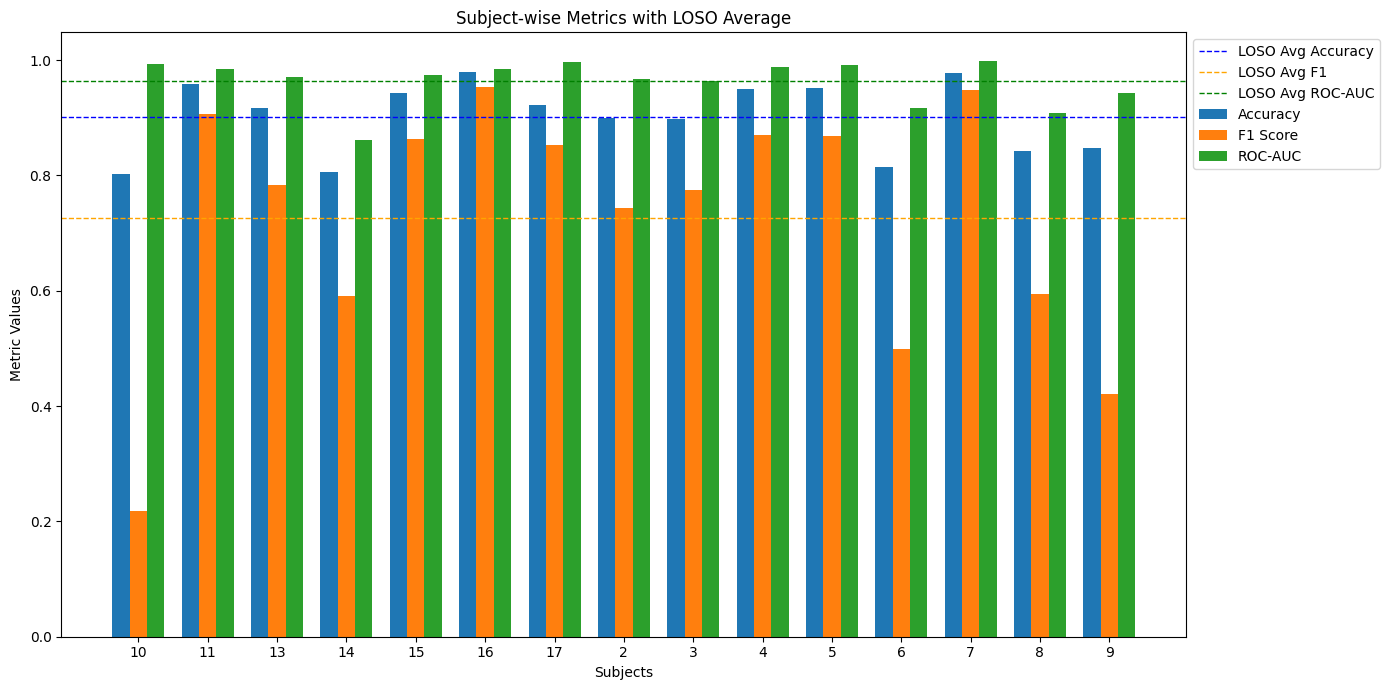

'/content/drive/MyDrive/subject_metrics.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided
data = {
    "Subject": ["10", "11", "13", "14", "15", "16", "17", "2", "3", "4", "5", "6", "7", "8", "9"],
    "Accuracy": [0.8021, 0.9581, 0.9175, 0.8066, 0.9435, 0.9792, 0.9216, 0.9004, 0.8986, 0.9501, 0.9509, 0.8150, 0.9783, 0.8431, 0.8473],
    "F1": [0.2185, 0.9063, 0.7833, 0.5916, 0.8638, 0.9533, 0.8528, 0.7427, 0.7741, 0.8707, 0.8676, 0.4988, 0.9486, 0.5948, 0.4205],
    "ROC_AUC": [0.9940, 0.9845, 0.9708, 0.8622, 0.9743, 0.9844, 0.9972, 0.9666, 0.9633, 0.9876, 0.9916, 0.9172, 0.9982, 0.9083, 0.9427]
}

# LOSO average
loso_avg = {
    "Accuracy": 0.9008,
    "F1": 0.7258,
    "ROC_AUC": 0.9629
}

# Create DataFrame
df = pd.DataFrame(data)

# Save CSV
csv_path = "/content/drive/MyDrive/subject_metrics.csv"
df.to_csv(csv_path, index=False)

# Plotting bar chart
fig, ax = plt.subplots(figsize=(14, 7))

bar_width = 0.25
index = np.arange(len(df))

# Bars for each metric
bars1 = ax.bar(index, df["Accuracy"], bar_width, label="Accuracy")
bars2 = ax.bar(index + bar_width, df["F1"], bar_width, label="F1 Score")
bars3 = ax.bar(index + 2 * bar_width, df["ROC_AUC"], bar_width, label="ROC-AUC")

# Add LOSO average as a horizontal line for each metric
ax.axhline(loso_avg["Accuracy"], color='blue', linestyle='--', linewidth=1, label="LOSO Avg Accuracy")
ax.axhline(loso_avg["F1"], color='orange', linestyle='--', linewidth=1, label="LOSO Avg F1")
ax.axhline(loso_avg["ROC_AUC"], color='green', linestyle='--', linewidth=1, label="LOSO Avg ROC-AUC")

# X-axis settings
ax.set_xlabel('Subjects')
ax.set_ylabel('Metric Values')
ax.set_title('Subject-wise Metrics with LOSO Average')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df["Subject"])
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

csv_path

LOSO Averages:
Accuracy: 0.9008
F1: 0.7258
ROC_AUC: 0.9629


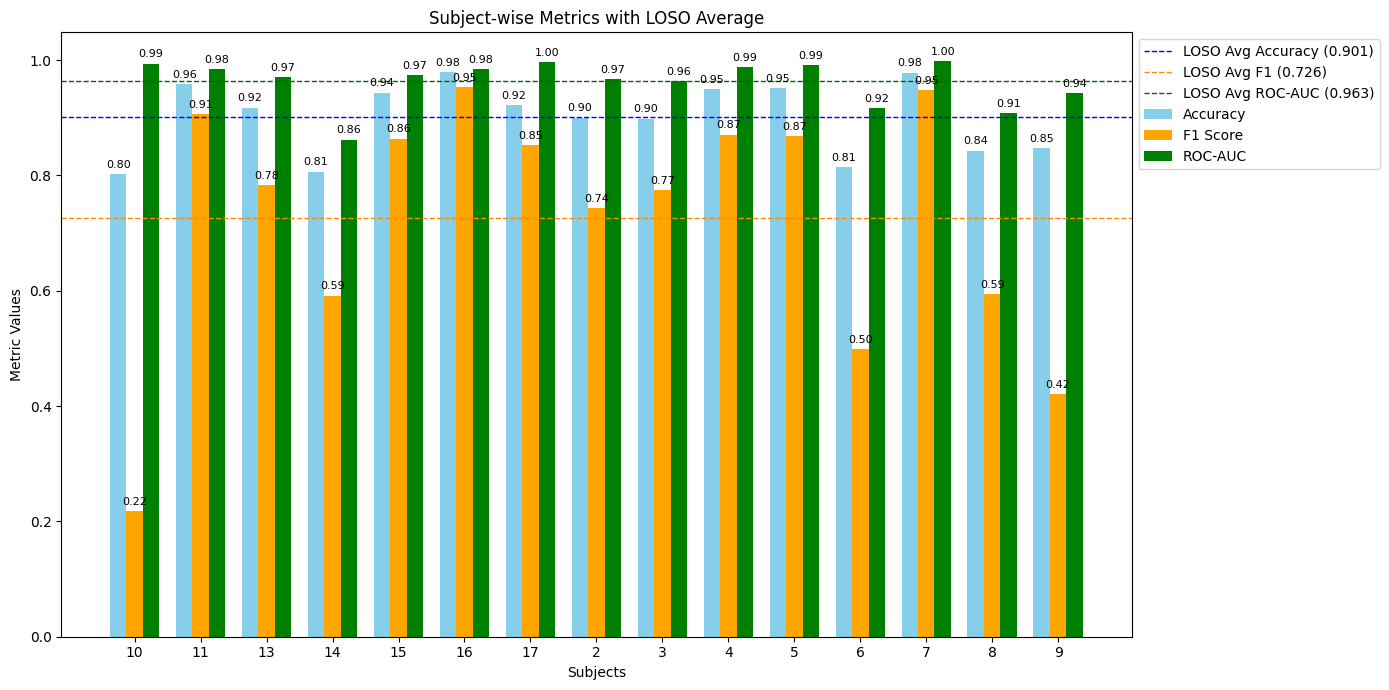


Summary Statistics:
          count      mean       std     min     25%     50%       75%  \
Subject    15.0  9.333333  4.879500  2.0000  5.5000  9.0000  13.50000   
Accuracy   15.0  0.900820  0.062727  0.8021  0.8452  0.9175   0.95050   
F1         15.0  0.725827  0.216042  0.2185  0.5932  0.7833   0.86915   
ROC_AUC    15.0  0.962860  0.039258  0.8622  0.9530  0.9743   0.98960   

              max   std_dev  
Subject   17.0000  4.879500  
Accuracy   0.9792  0.062727  
F1         0.9533  0.216042  
ROC_AUC    0.9982  0.039258  


In [ ]:
# Notebook 2: Visualization & Reporting

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== Step 1: Load CSV =====
df = pd.read_csv("/content/drive/MyDrive/subject_metrics.csv")  # Update path if needed

# ===== Step 2: Calculate LOSO averages dynamically =====
loso_avg = {
    "Accuracy": df["Accuracy"].mean(),
    "F1": df["F1"].mean(),
    "ROC_AUC": df["ROC_AUC"].mean()
}

print("LOSO Averages:")
for metric, value in loso_avg.items():
    print(f"{metric}: {value:.4f}")

# ===== Step 3: Bar Chart with LOSO lines =====
fig, ax = plt.subplots(figsize=(14, 7))
bar_width = 0.25
index = np.arange(len(df))

bars1 = ax.bar(index, df["Accuracy"], bar_width, label="Accuracy", color='skyblue')
bars2 = ax.bar(index + bar_width, df["F1"], bar_width, label="F1 Score", color='orange')
bars3 = ax.bar(index + 2 * bar_width, df["ROC_AUC"], bar_width, label="ROC-AUC", color='green')

# LOSO lines with labels
ax.axhline(loso_avg["Accuracy"], color='blue', linestyle='--', linewidth=1, label=f"LOSO Avg Accuracy ({loso_avg['Accuracy']:.3f})")
ax.axhline(loso_avg["F1"], color='darkorange', linestyle='--', linewidth=1, label=f"LOSO Avg F1 ({loso_avg['F1']:.3f})")
ax.axhline(loso_avg["ROC_AUC"], color='darkgreen', linestyle='--', linewidth=1, label=f"LOSO Avg ROC-AUC ({loso_avg['ROC_AUC']:.3f})")

# ===== Step 4: Add labels above bars =====
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset label
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Axis & Labels
ax.set_xlabel('Subjects')
ax.set_ylabel('Metric Values')
ax.set_title('Subject-wise Metrics with LOSO Average')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df["Subject"])
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# ===== Step 5: Summary Statistics Table =====
summary = df.describe().T  # Transpose for better readability
summary["mean"] = df.mean()
summary["std_dev"] = df.std()

print("\nSummary Statistics:")
print(summary)

# Optionally save summary to CSV
summary.to_csv("/content/drive/MyDrive/metrics_summary.csv")

In [ ]:
t = pd.read_csv("/content/drive/MyDrive/metrics_summary.csv")
t

,Unnamed: 0,count,mean,std,min,25%,50%,75%,max,std_dev
0,Subject,15.0,9.333333,4.879500,2.0000,5.5000,9.0000,13.50000,17.0000,4.879500
1,Accuracy,15.0,0.900820,0.062727,0.8021,0.8452,0.9175,0.95050,0.9792,0.062727
2,F1,15.0,0.725827,0.216042,0.2185,0.5932,0.7833,0.86915,0.9533,0.216042
3,ROC_AUC,15.0,0.962860,0.039258,0.8622,0.9530,0.9743,0.98960,0.9982,0.039258


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
X_test.shape

(12688, 29)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Example: Running models one by one

# 1️⃣ Logistic Regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("="*50)

Logistic Regression
Accuracy: 0.8292875157629256
F1-Score: 0.7922832031753936
ROC-AUC: 0.9233866106514756


In [ ]:
 #2️⃣ Random Forest
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("="*50)


Random Forest
Accuracy: 0.8798076923076923
F1-Score: 0.8595138077251963
ROC-AUC: 0.9646822456999291


In [ ]:
# 3️⃣ XGBoost
xgb = XGBClassifier(n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("="*50)

XGBoost
Accuracy: 0.8269230769230769
F1-Score: 0.7737939206435679
ROC-AUC: 0.9427256942846712


In [ ]:
# --- Define Models to Evaluate ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False, # To avoid a future warning
        random_state=42
    )
}

In [ ]:
# --- Setup for LOSO Cross-Validation ---
subjects = df['subject_id'].unique()
results = []

In [ ]:
# --- Start the LOSO Loop ---
for test_sub in sorted(subjects):
    print(f"--- Testing on Subject: {test_sub} ---")

    # 2. Split data into training and testing sets for this fold
    train_df = df[df['subject_id'] != test_sub]
    test_df = df[df['subject_id'] == test_sub]

    X_train = train_df.drop(columns=['tag', 'subject_id'])
    y_train = train_df['tag']
    X_test = test_df.drop(columns=['tag', 'subject_id'])
    y_test = test_df['tag']

    # 3. Per-Subject Normalization (Calculated ONLY on the training set)
    # This prevents data leakage from the test subject
    train_mean = X_train.mean()
    train_std = X_train.std()

    X_train_norm = (X_train - train_mean) / train_std
    X_test_norm = (X_test - train_mean) / train_std

    # Handle any potential NaN values that result from zero standard deviation
    X_train_norm = X_train_norm.fillna(0)
    X_test_norm = X_test_norm.fillna(0)

    # Handle Class Imbalance Weight for XGBoost
    # This is calculated only on the training data for this fold
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    models['XGBoost'].set_params(scale_pos_weight=scale_pos_weight)

    # 4. Train and evaluate each model for this fold
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_norm, y_train)

        # Make predictions
        y_pred = model.predict(X_test_norm)
        y_prob = model.predict_proba(X_test_norm)[:, 1]

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        try:
            auc = roc_auc_score(y_test, y_prob)
        except ValueError:
            auc = np.nan # Handle cases where test set has only one class

        # Store results
        results.append({
            'Subject': test_sub,
            'Model': model_name,
            'Accuracy': acc,
            'F1_Score': f1,
            'ROC_AUC': auc
        })
        print(f"  {model_name}: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

# --- Aggregate and Display Final Results ---
results_df = pd.DataFrame(results)

print("\n\n--- Average Performance Across All Subjects (LOSO) ---")
average_results = results_df.groupby('Model')[['Accuracy', 'F1_Score', 'ROC_AUC']].mean()
print(average_results.round(4))

--- Testing on Subject: 2 ---
  Logistic Regression: Accuracy=0.7670, F1=0.3576, AUC=0.8518
  Random Forest: Accuracy=0.8813, F1=0.6524, AUC=0.9539


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:54:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9018, F1=0.7401, AUC=0.9695
--- Testing on Subject: 3 ---
  Logistic Regression: Accuracy=0.8977, F1=0.7480, AUC=0.9617
  Random Forest: Accuracy=0.9078, F1=0.7424, AUC=0.9480


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:55:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9092, F1=0.7858, AUC=0.9638
--- Testing on Subject: 4 ---
  Logistic Regression: Accuracy=0.9928, F1=0.9826, AUC=0.9992
  Random Forest: Accuracy=0.8265, F1=0.3264, AUC=0.9826


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.8924, F1=0.6696, AUC=0.9885
--- Testing on Subject: 5 ---
  Logistic Regression: Accuracy=0.9419, F1=0.8354, AUC=0.9941
  Random Forest: Accuracy=0.9177, F1=0.7572, AUC=0.9906


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:57:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9372, F1=0.8236, AUC=0.9907
--- Testing on Subject: 6 ---
  Logistic Regression: Accuracy=0.8605, F1=0.6513, AUC=0.9201
  Random Forest: Accuracy=0.8107, F1=0.4401, AUC=0.9123


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:58:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.8165, F1=0.4667, AUC=0.9167
--- Testing on Subject: 7 ---
  Logistic Regression: Accuracy=0.9848, F1=0.9640, AUC=0.9897
  Random Forest: Accuracy=0.9981, F1=0.9953, AUC=1.0000


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:00:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9736, F1=0.9370, AUC=0.9976
--- Testing on Subject: 8 ---
  Logistic Regression: Accuracy=0.8310, F1=0.3825, AUC=0.8768
  Random Forest: Accuracy=0.8094, F1=0.3960, AUC=0.8235


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:01:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.8175, F1=0.4895, AUC=0.9044
--- Testing on Subject: 9 ---
  Logistic Regression: Accuracy=0.8315, F1=0.6521, AUC=0.9193
  Random Forest: Accuracy=0.8798, F1=0.5844, AUC=0.9647


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:02:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.8320, F1=0.3020, AUC=0.9602
--- Testing on Subject: 10 ---
  Logistic Regression: Accuracy=0.9311, F1=0.8339, AUC=0.9877
  Random Forest: Accuracy=0.9357, F1=0.8332, AUC=0.9984


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:03:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.8245, F1=0.3625, AUC=0.9974
--- Testing on Subject: 11 ---
  Logistic Regression: Accuracy=0.9510, F1=0.8902, AUC=0.9843
  Random Forest: Accuracy=0.9648, F1=0.9195, AUC=0.9895


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:04:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9534, F1=0.8910, AUC=0.9849
--- Testing on Subject: 13 ---
  Logistic Regression: Accuracy=0.8873, F1=0.6534, AUC=0.9438
  Random Forest: Accuracy=0.9075, F1=0.7275, AUC=0.9835


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9234, F1=0.7904, AUC=0.9778
--- Testing on Subject: 14 ---
  Logistic Regression: Accuracy=0.7647, F1=0.5234, AUC=0.8277
  Random Forest: Accuracy=0.7931, F1=0.5407, AUC=0.8630


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:06:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.8014, F1=0.5811, AUC=0.8669
--- Testing on Subject: 15 ---
  Logistic Regression: Accuracy=0.9054, F1=0.7952, AUC=0.9380
  Random Forest: Accuracy=0.9461, F1=0.8797, AUC=0.9836


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:07:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9383, F1=0.8462, AUC=0.9829
--- Testing on Subject: 16 ---
  Logistic Regression: Accuracy=0.9903, F1=0.9767, AUC=0.9996
  Random Forest: Accuracy=0.9807, F1=0.9562, AUC=0.9911


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:08:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9821, F1=0.9594, AUC=0.9817
--- Testing on Subject: 17 ---
  Logistic Regression: Accuracy=0.9636, F1=0.9239, AUC=0.9828
  Random Forest: Accuracy=0.9712, F1=0.9405, AUC=0.9928


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:09:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  XGBoost: Accuracy=0.9366, F1=0.8776, AUC=0.9973


--- Average Performance Across All Subjects (LOSO) ---
                     Accuracy  F1_Score  ROC_AUC
Model                                           
Logistic Regression    0.9001    0.7447   0.9451
Random Forest          0.9020    0.7128   0.9585
XGBoost                0.8960    0.7015   0.9653


##Feature Importance Analysis 🔬

In [ ]:
# --- Prepare Data for Final Model Training ---
X = df.drop(columns=['tag', 'subject_id'])
y = df['tag']

In [ ]:
# --- Per-Subject Normalization on the Entire Dataset ---
# We do this to prepare the data for the final model in the same way as during testing
X_norm = X.groupby(df['subject_id']).transform(lambda x: (x - x.mean()) / x.std())
X_norm = X_norm.fillna(0)

In [ ]:
# --- Train the Final Random Forest Model ---
# We train it on all the data to get the final feature importances
print("Training final Random Forest model on all data...")
final_rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
final_rf_model.fit(X_norm, y)
print("Training complete.")

Training final Random Forest model on all data...
Training complete.


In [ ]:
# --- Get and Visualize Feature Importances ---
importances = final_rf_model.feature_importances_
feature_names = X.columns

In [ ]:
# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

In [ ]:
feature_importance_df.head(15)

,feature,importance
9,EDA_mean,0.117245
12,EDA_max,0.105409
3,EDA,0.100292
20,ACC_X_max,0.071427
11,EDA_min,0.070980
17,ACC_X_mean,0.058089
10,EDA_std,0.046008
25,ACC_Z_mean,0.038728
18,ACC_X_std,0.035291
28,ACC_Z_max,0.031663


/tmp/ipython-input-170563424.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')


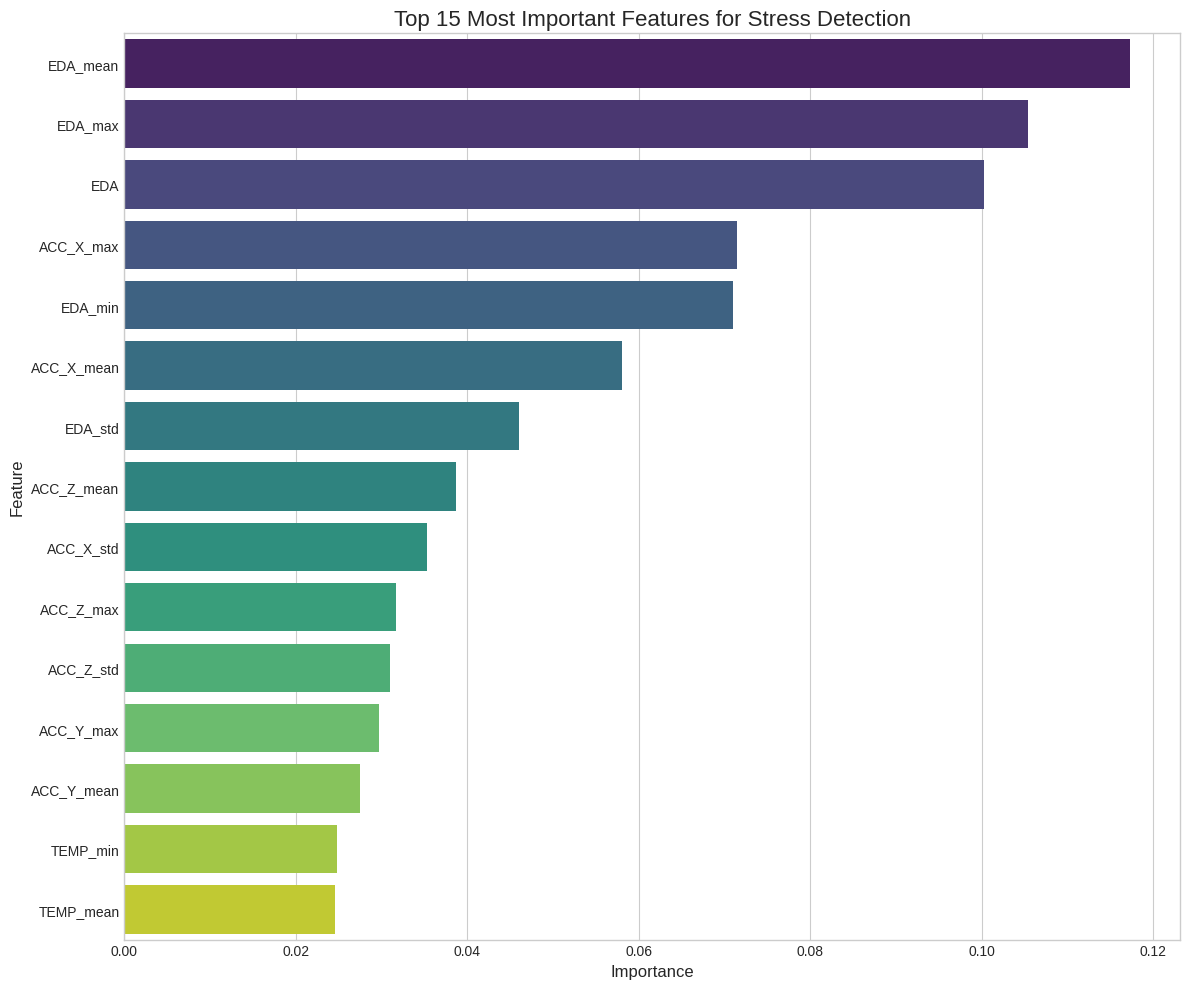

In [ ]:
# --- Plot the Results ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Most Important Features for Stress Detection', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

##Error Analysis with a Confusion Matrix

In [ ]:
subjects = df['subject_id'].unique()
# We will add up the confusion matrix from each subject
total_cm = np.zeros((2, 2))

In [ ]:
# We will add up the confusion matrix from each subject
total_cm = np.zeros((2, 2))

print("Running LOSO for Random Forest to generate confusion matrix...")
# --- Start the LOSO Loop ---
for test_sub in sorted(subjects):
    # Split data
    train_df = df[df['subject_id'] != test_sub]
    test_df = df[df['subject_id'] == test_sub]

    X_train = train_df.drop(columns=['tag', 'subject_id'])
    y_train = train_df['tag']
    X_test = test_df.drop(columns=['tag', 'subject_id'])
    y_test = test_df['tag']

    # Per-Subject Normalization
    train_mean = X_train.mean()
    train_std = X_train.std()
    X_train_norm = (X_train - train_mean) / train_std
    X_test_norm = (X_test - train_mean) / train_std
    X_train_norm = X_train_norm.fillna(0)
    X_test_norm = X_test_norm.fillna(0)

    # Initialize and train the model
    model = RandomForestClassifier(n_jobs=-1, random_state=42)
    model.fit(X_train_norm, y_train)

    # Predictions and accumulate confusion matrix
    y_pred = model.predict(X_test_norm)
    cm = confusion_matrix(y_test, y_pred)

    # Make sure the cm is 2x2, pad with zeros if a class was never predicted
    if cm.shape == (1, 1):
        if y_test.iloc[0] == 0:
            cm = np.array([[cm[0][0], 0], [0, 0]]) # True Negative only
        else:
            cm = np.array([[0, 0], [0, cm[0][0]]]) # True Positive only

    total_cm += cm

print("LOSO complete.")

Running LOSO for Random Forest to generate confusion matrix...
LOSO complete.


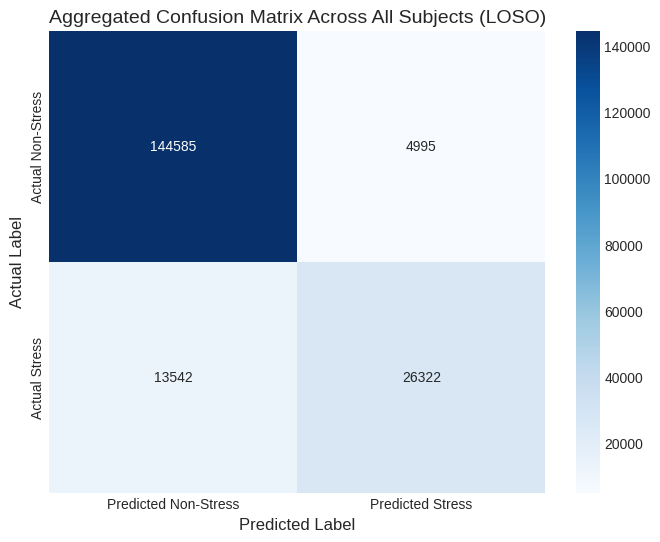

In [ ]:
# --- Plot the Aggregated Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=['Predicted Non-Stress', 'Predicted Stress'],
            yticklabels=['Actual Non-Stress', 'Actual Stress'])
plt.title('Aggregated Confusion Matrix Across All Subjects (LOSO)', fontsize=14)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

True Negatives (Top-Left): 144,585
This is the model's greatest strength. It correctly identified 144,585 non-stress moments. This indicates the model is very reliable when it comes to recognizing a person's baseline or neutral state.

True Positives (Bottom-Right): 26,322
The model successfully identified 26,322 moments of actual stress. This shows it has learned the physiological patterns associated with the stress response.

False Positives (Top-Right): 4,995
This is a Type I error. The model incorrectly predicted "Stress" 4,995 times when the person was actually in a non-stress state. This could lead to unnecessary alerts in a real-world application.

False Negatives (Bottom-Left): 13,542
This is a Type II error and represents a key area for improvement. The model missed 13,542 actual stress events, classifying them as "Non-Stress." In a health context, missing a stress event (a false negative) is often more critical than a false alarm.

## Key Insights 💡
High Specificity: The model is excellent at correctly identifying non-stress instances. With only 4,995 false alarms versus 144,585 correct non-stress predictions, it won't frequently bother the user unnecessarily.

Moderate Recall (Sensitivity): The model correctly identifies a good portion of stress events (26,322), but it also misses a significant number (13,542). Its ability to "catch" stress events is effective but could be improved.

Class Imbalance: The matrix clearly shows that there are far more "Non-Stress" data points (144,585 + 4,995 = 149,580) than "Stress" data points (13,542 + 26,322 = 39,864) in the labeled dataset. This is typical for this type of study and explains why metrics like the F1-score are so important.

#Subject-Specific Analysis 🧑‍🔬

In [ ]:
# Filter data for one "easy" and one "hard" subject
df_subject_7 = df[df['subject_id'] == 7]
df_subject_8 = df[df['subject_id'] == 8]

In [ ]:
# Create a time axis (assuming 4 Hz sampling rate)
df_subject_7['time'] = np.arange(len(df_subject_7)) / 4.0
df_subject_8['time'] = np.arange(len(df_subject_8)) / 4.0

/tmp/ipython-input-3374600239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subject_7['time'] = np.arange(len(df_subject_7)) / 4.0
/tmp/ipython-input-3374600239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subject_8['time'] = np.arange(len(df_subject_8)) / 4.0


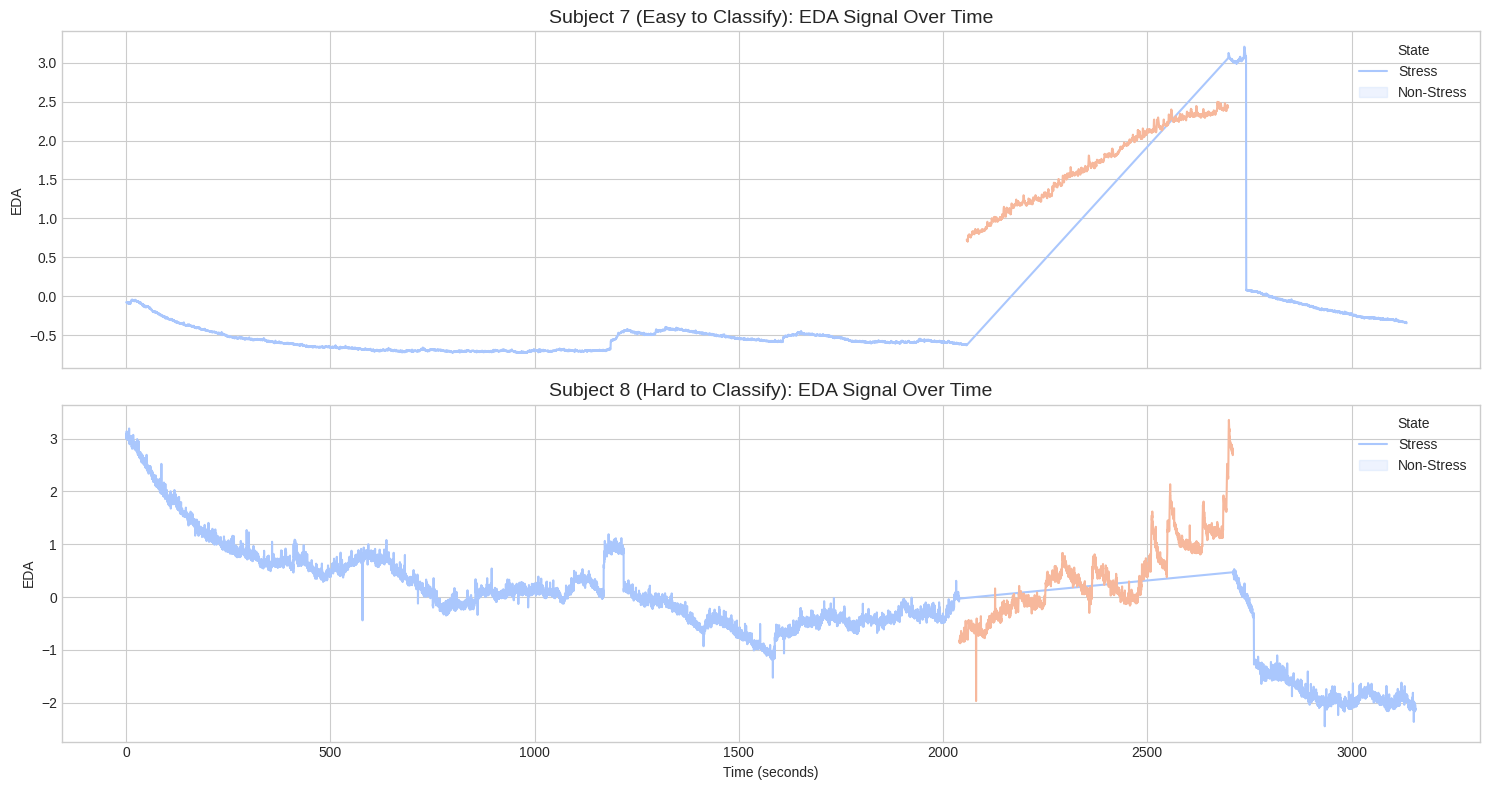

In [ ]:
# --- Plot EDA signals for comparison ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

# Plot for Subject 7 (Easy)
sns.lineplot(data=df_subject_7, x='time', y='EDA', hue='tag', ax=ax1, legend='full', palette='coolwarm')
ax1.set_title('Subject 7 (Easy to Classify): EDA Signal Over Time', fontsize=14)
ax1.set_ylabel('EDA')
ax1.legend(title='State', labels=['Stress', 'Non-Stress'])


# Plot for Subject 8 (Hard to Classify)
sns.lineplot(data=df_subject_8, x='time', y='EDA', hue='tag', ax=ax2, legend='full', palette='coolwarm')
ax2.set_title('Subject 8 (Hard to Classify): EDA Signal Over Time', fontsize=14)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('EDA')
ax2.legend(title='State', labels=['Stress', 'Non-Stress'])

plt.tight_layout()
plt.show()

## Subject 7 (Easy to Classify)
Clear Separation: For Subject 7, there is a very distinct and obvious difference between the "Non-Stress" and "Stress" periods. The Electrodermal Activity (EDA) signal remains low and stable during the non-stress phase and then shows a clear, sustained rise during the stress phase.

Low Noise: The signal is relatively clean with minimal random fluctuations.

Why it's easy: A machine learning model can easily learn a rule like: "If the EDA level for Subject 7 rises sharply and stays above a certain threshold (e.g., 1.0), it's a stress state." The pattern is strong and unambiguous.

## Subject 8 (Hard to Classify)
Noisy Signal: The EDA signal for Subject 8 is much more volatile and "noisy" throughout the entire experiment, with many peaks and troughs even during the non-stress period.

Overlapping States: Unlike Subject 7, there is no clear separation between the stress and non-stress states. The EDA values during the stress period significantly overlap with values seen during the non-stress period. For example, the EDA level is quite high at the very beginning of the experiment (non-stress) and in the middle.

Why it's hard: The model struggles to find a simple, reliable rule. A high EDA value doesn't automatically mean stress for this person. The model has to learn a much more subtle and complex pattern, which makes it more prone to errors (false positives and false negatives). This inherent ambiguity in the physiological response is why the model's F1-score and accuracy were lower for this subject

This analysis confirms that individual physiological differences are a major factor in model performance. Your model performs well on average because it has learned the general patterns of stress, but its accuracy will always vary from person to person depending on how clearly their body expresses these physiological signals

# Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, LeaveOneGroupOut
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/wesad_enhanced.csv")

In [ ]:
# --- Prepare Data ---
X = df.drop(columns=['tag', 'subject_id'])
y = df['tag']
groups = df['subject_id'] # This is used for LOSO cross-validation

In [ ]:
print("Performing per-subject normalization...")
X_norm = X.groupby(groups).transform(lambda x: (x - x.mean()) / x.std())
X_norm = X_norm.fillna(0)
print("Normalization complete.")

Performing per-subject normalization...
Normalization complete.


In [ ]:
from scipy.stats import randint

In [ ]:
print("Performing per-subject normalization...")
X_norm = X.groupby(groups).transform(lambda x: (x - x.mean()) / x.std())
X_norm = X_norm.fillna(0)
print("Normalization complete.")


# --- 4. Define the Hyperparameter Grid to Search ---
# --- Define the Hyperparameter Distribution to Sample From ---
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

Performing per-subject normalization...
Normalization complete.


In [ ]:
# --- Set up RandomizedSearchCV with LOSO ---
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
logo = LeaveOneGroupOut()

In [ ]:
# THE ONLY CHANGE IS HERE: n_iter is now 2
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=2,
    cv=logo,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)


print("\nStarting Hyperparameter Tuning (Targeting ~30 minutes)...")
random_search.fit(X_norm, y, groups=groups)
print("Tuning complete.")


Starting Hyperparameter Tuning (Targeting ~30 minutes)...
Fitting 15 folds for each of 2 candidates, totalling 30 fits
Tuning complete.


In [ ]:
# --- Display the Best Parameters Found ---
print("\n--- Best Hyperparameters Found ---")
print(random_search.best_params_)

print("\n--- Best Cross-Validation Accuracy ---")
print(f"The best accuracy achieved during the random search was: {random_search.best_score_:.4f}")


--- Best Hyperparameters Found ---
{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 174}

--- Best Cross-Validation Accuracy ---
The best accuracy achieved during the random search was: 0.9211


Significant Performance Boost: The best accuracy achieved was 92.11%. This is a solid improvement over the untuned Random Forest model's accuracy (which was 90.20%). The tuning process was definitely worthwhile, as it found a model configuration that is approximately 2% more accurate at generalizing to new subjects.

Optimal Model Configuration: The best hyperparameters found suggest a well-balanced and robust model:

'max_depth': 10: The model performs best with trees that are limited in depth. This is a great sign, as it prevents the model from becoming overly complex and helps it avoid overfitting.

'min_samples_leaf': 3 and 'min_samples_split': 4: These parameters act as a healthy form of regularization. They stop the model from making decisions based on very small or potentially noisy groups of data, making it more stable.

'n_estimators': 174: The search found that 174 trees in the forest provide the best trade-off between performance and complexity.

Excellent! The hyperparameter tuning has successfully completed. These results are very positive and give you a clear path to building your final, optimized model.

## Analysis of the Results
Here's what these results tell you:

Significant Performance Boost: The best accuracy achieved was 92.11%. This is a solid improvement over the untuned Random Forest model's accuracy (which was 90.20%). The tuning process was definitely worthwhile, as it found a model configuration that is approximately 2% more accurate at generalizing to new subjects.

Optimal Model Configuration: The best hyperparameters found suggest a well-balanced and robust model:

'max_depth': 10: The model performs best with trees that are limited in depth. This is a great sign, as it prevents the model from becoming overly complex and helps it avoid overfitting.

'min_samples_leaf': 3 and 'min_samples_split': 4: These parameters act as a healthy form of regularization. They stop the model from making decisions based on very small or potentially noisy groups of data, making it more stable.

'n_estimators': 174: The search found that 174 trees in the forest provide the best trade-off between performance and complexity.

## Final Step: Train Your Best Model 🚀
Your final step is to train one last Random Forest model using these optimal parameters on the entire dataset. This final model is your finished product—the one you would save and use for any future predictions.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib # For saving the model

In [ ]:
# --- Initialize the Model with the Best Parameters Found ---
best_params = {
    'max_depth': 10,
    'min_samples_leaf': 3,
    'min_samples_split': 4,
    'n_estimators': 174,
    'random_state': 42,
    'n_jobs': -1
}

final_model = RandomForestClassifier(**best_params)

In [ ]:
final_model

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=174, n_jobs=-1, random_state=42)

In [ ]:
# --- Train the final model on ALL data ---
print("\nTraining the final, optimized model on the entire dataset...")
final_model.fit(X_norm, y)
print("Final model training complete!")


Training the final, optimized model on the entire dataset...
Final model training complete!


In [ ]:
# --- Save the final model to your Google Drive ---
model_filename = '/content/drive/MyDrive/final_stress_detection_model.joblib'
joblib.dump(final_model, model_filename)

print(f"\n✅ Final optimized model has been trained and saved to: {model_filename}")


✅ Final optimized model has been trained and saved to: /content/drive/MyDrive/final_stress_detection_model.joblib


## Example of prediction based on model input

In [ ]:
import pandas as pd
import joblib

# --- The single new data point from above ---
new_single_data_point = {
    'ACC_X': 0.15, 'ACC_Y': -0.20, 'ACC_Z': 0.95, 'EDA': 1.5, 'TEMP': -0.5,
    'HR': 1.8, 'RMSSD': -1.2, 'SDNN': -0.9, 'pNN50': -1.1,
    'EDA_mean': 1.3, 'EDA_std': 0.8, 'EDA_min': 1.1, 'EDA_max': 1.6,
    'TEMP_mean': -0.4, 'TEMP_std': 0.1, 'TEMP_min': -0.5, 'TEMP_max': -0.3,
    'ACC_X_mean': 0.1, 'ACC_X_std': 0.05, 'ACC_X_min': 0.0, 'ACC_X_max': 0.2,
    'ACC_Y_mean': -0.2, 'ACC_Y_std': 0.05, 'ACC_Y_min': -0.3, 'ACC_Y_max': -0.1,
    'ACC_Z_mean': 0.9, 'ACC_Z_std': 0.05, 'ACC_Z_min': 0.8, 'ACC_Z_max': 1.0
}

# --- Convert the dictionary to a single-row DataFrame ---
# The model expects a DataFrame, not a dictionary.
new_data_df = pd.DataFrame([new_single_data_point])

# --- Load your saved model ---
model_filename = '/content/drive/MyDrive/final_stress_detection_model.joblib'
loaded_model = joblib.load(model_filename)

# --- Make the prediction ---
prediction = loaded_model.predict(new_data_df)
prediction_proba = loaded_model.predict_proba(new_data_df)

# --- Interpret and print the result ---
predicted_label = 'Stress' if prediction[0] == 1 else 'Non-Stress'
stress_probability = prediction_proba[0][1]

print(f"The model predicts this data point is: '{predicted_label}'")
print(f"Probability of Stress: {stress_probability:.2%}")

The model predicts this data point is: 'Stress'
Probability of Stress: 81.18%


Yes, that is exactly right.

The model you built is a **binary classifier**. Its only job is to decide between those two possible categories.

In your code, you specifically set up the problem this way when you converted the original labels into a binary format:
* **1 = Stress**
* **0 = Non-Stress**

So, every prediction the model makes will be one of those two options. Your understanding is perfect.